In [1]:
import sys
sys.path.append('../src')
from recommender_system.MAB import LinUCB, KernelUCB, offlineEvaluate
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.model_selection import train_test_split
import importlib
import recommender_system.MAB
importlib.reload(recommender_system.MAB)
from recommender_system.MAB import LinUCB, KernelUCB, offlineEvaluate

import pandas as pd
import numpy as np

/Users/alubis/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
events_path = '../../data/events.csv'
events = pd.read_csv(events_path)

item_props1 = pd.read_csv('../../data/item_properties_part1.csv')
item_props2 = pd.read_csv('../../data/item_properties_part2.csv')
item_properties = pd.concat([item_props1, item_props2], ignore_index=True)
category_tree = pd.read_csv('../../data/category_tree.csv')

In [3]:
# Reduce dataset size to prevent memory issues
print(f"Original events shape: {events.shape}")

# Sample
events = events.sample(frac=0.9, random_state=42)
print(f"After sampling: {events.shape}")

# Filter sparse users/items
min_user_events = 5
min_item_events = 5
user_counts = events['visitorid'].value_counts()
item_counts = events['itemid'].value_counts()
events = events[events['visitorid'].isin(user_counts[user_counts >= min_user_events].index)]
events = events[events['itemid'].isin(item_counts[item_counts >= min_item_events].index)]
print(f"After filtering: {events.shape}")

Original events shape: (2756101, 5)
After sampling: (2480491, 5)
After filtering: (762887, 5)


In [4]:
# Candidate Generation using Collaborative Filtering (ALS)

# Add weight column based on event type
event_weights = {'view': 1, 'addtocart': 3, 'transaction': 5}
events['weight'] = events['event'].map(event_weights)

# Create User-Item Matrix
user_item_matrix = events.pivot_table(
    index='visitorid', 
    columns='itemid', 
    values='weight', 
    aggfunc='sum',
    fill_value=0
)
user_item_sparse = csr_matrix(user_item_matrix.values)

# Build user and item maps for ALS
user_map = dict(enumerate(user_item_matrix.index))
item_map = dict(enumerate(user_item_matrix.columns))
user_inv_map = {v: k for k, v in user_map.items()}
item_inv_map = {v: k for k, v in item_map.items()}

# Train ALS model
als_model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20)
als_model.fit(user_item_sparse.T)

print("ALS model trained.")

/var/folders/vj/s2ljwj2n1479d7jxy_gm52mw0000gn/T/ipykernel_37700/1374947685.py:8: PerformanceWarning: The following operation may generate 4390283320 cells in the resulting pandas object.
  user_item_matrix = events.pivot_table(
/Users/alubis/Library/Python/3.11/lib/python/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 10 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
/Users/alubis/Library/Python/3.11/lib/python/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0026471614837646484 seconds
  warnings.warn(
100%|██████████| 20/20 [00:04<00:00,  4.82it/s]

ALS model trained.


In [5]:
# HYBRID APPROACH: ALS generates candidates, Bandits select from them

events_sorted = events.sort_values(['visitorid', 'timestamp'])
reward_map = {'view': 0.1, 'addtocart': 0.5, 'transaction': 1.0}
events_sorted['reward'] = events_sorted['event'].map(reward_map)

# Prepare data for bandits with ALS-generated candidates
data_list = []
n_candidates = 20  # ALS will generate 20 candidates per user

grouped = events_sorted.groupby('visitorid')
events_used = 0
events_skipped = 0

for visitor, group in grouped:
    # Check if user is in ALS training data
    if visitor not in user_inv_map:
        events_skipped += len(group)
        continue
    
    user_idx = user_inv_map[visitor]
    past_views = 0
    past_addtocart = 0
    past_transactions = 0
    
    for _, row in group.iterrows():
        # Get ALS recommendations (candidates) for this user
        try:
            user_row = user_item_sparse[user_idx]
            als_recs = als_model.recommend(
                user_idx,
                user_row,
                N=n_candidates,
                filter_already_liked_items=False
            )
            candidate_indices, scores = als_recs
            candidate_items = [item_map[idx] for idx in candidate_indices if idx in item_map]
            
            # Check if the actual item from history is in the candidates
            actual_item = row['itemid']
            if actual_item in candidate_items:
                # Find position (arm) of actual item in candidate list
                arm = candidate_items.index(actual_item)
                reward = row['reward']
                
                # User state: [past_views, past_addtocart, past_transactions]
                user_state = np.array([past_views, past_addtocart, past_transactions], dtype=float)
                
                # Context: same user state for each candidate (n_candidates arms, 3 dims)
                contexts = np.tile(user_state, (n_candidates, 1))
                row_data = np.concatenate([[arm, reward], contexts.flatten()])
                data_list.append(row_data)
                events_used += 1
            else:
                events_skipped += 1
                
        except Exception as e:
            events_skipped += 1
            continue
        
        # Update user state
        if row['event'] == 'view':
            past_views += 1
        elif row['event'] == 'addtocart':
            past_addtocart += 1
        elif row['event'] == 'transaction':
            past_transactions += 1

data_array = np.array(data_list)
np.savetxt('../../data/dataset_hybrid.txt', data_array)
print(f"Hybrid dataset saved: {events_used} events used, {events_skipped} events skipped")
print(f"Dataset shape: {data_array.shape}")

print(f"ALS generates {n_candidates} candidates per user")
print(f"Bandit learns to select the best one from these {n_candidates} options")

Hybrid dataset saved: 274 events used, 762613 events skipped
Dataset shape: (274, 62)
ALS generates 20 candidates per user
Bandit learns to select the best one from these 20 options


In [6]:
# Load hybrid dataset (ALS candidates + Bandit selection)
data = np.loadtxt('../../data/dataset_hybrid.txt')
arms, rewards, contexts = data[:,0], data[:,1], data[:,2:]
arms = arms.astype(int)
rewards = rewards.astype(float)
contexts = contexts.astype(float)

# Now bandits choose from 20 ALS-generated candidates
n_arms = 20
n_events = len(contexts)
n_dims = int(len(contexts[0])/n_arms)
contexts = contexts.reshape(n_events, n_arms, n_dims)
print(f"n_arms: {n_arms}, n_dims: {n_dims}, n_events: {n_events}")

n_arms: 20, n_dims: 3, n_events: 274


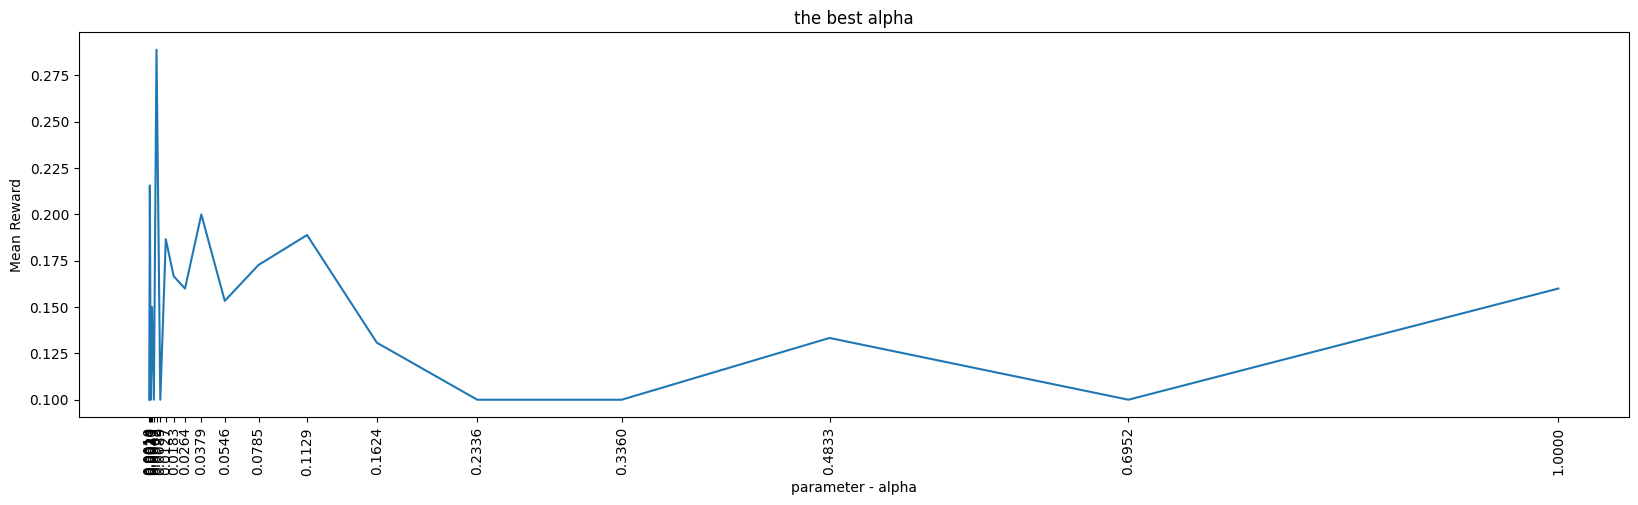

The best alpha for LinUCB is 0.006 with reward 0.2888888888888889


In [7]:
# hyperparameter optimization for LinUCB
alpha_list = np.logspace(-3,0,num= 20)    # generate valid alpha values
n_rounds = 800                            # set the initial number of round
max_reward = -np.inf                      # set the initial max reward
best_alpha = None                         # set the initial best alpha
results = []

# run with a set of alpha
for alpha in alpha_list:
    grid_mab = LinUCB(n_arms, n_dims, alpha)
    temp_result = offlineEvaluate(grid_mab, arms, rewards, contexts, n_rounds)
    temp_result = np.mean(temp_result)
    results.append(temp_result)
    if temp_result > max_reward:  # get the maximum mean rewards with the best alpha
        best_alpha = alpha
        max_reward = temp_result

# show the plot
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(alpha_list,results)
plt.xticks(alpha_list, rotation = 'vertical')
plt.title('the best alpha')
plt.ylabel('Mean Reward')
plt.xlabel('parameter - alpha')
plt.show()
print("The best alpha for LinUCB is", round(best_alpha, 3), "with reward", max_reward)

In [8]:
# hyperparameter optimization for KernelUCB
gamma_list = np.linspace(0, 1, num = 11)[1:]       # generate valid gamma values & remove 0.0
eta_list = np.linspace(0, 0.5, num = 11)[1:]       # generate valid eta values & remove 0.0
n_rounds = 100                                    # set the initial number of round
gam_max_reward, eta_max_reward = -np.inf, -np.inf  # set the initial max reward for gamma and eta

# get the maximum mean rewards with the the initial eta
eta = 0.1
for gam in gamma_list:
    grid_mab = KernelUCB(n_arms, n_dims, gam, eta, rbf_kernel)
    temp_result = offlineEvaluate(grid_mab, arms, rewards, contexts, n_rounds)
    temp_result = np.mean(temp_result)
    if temp_result > gam_max_reward:      # get the maximum mean rewards with the best eta and gamma
        gam_max_reward = temp_result  
        best_gamma = gam

print("The best gamma for Kernel UCB is {", round(best_gamma, 3), "} with reward", gam_max_reward)

for eta in eta_list:
    grid_mab = KernelUCB(n_arms, n_dims, best_gamma, eta, rbf_kernel)
    temp_result = offlineEvaluate(grid_mab, arms, rewards, contexts, n_rounds)
    temp_result = np.mean(temp_result)
    if temp_result > eta_max_reward:   # get the maximum mean rewards with the best gamma
        eta_max_reward = temp_result
        best_eta =  eta
        
print("The best eta for Kernel UCB is {", round(best_eta, 3), "} with reward", eta_max_reward)

The best gamma for Kernel UCB is { 0.3 } with reward 0.22000000000000003
The best eta for Kernel UCB is { 0.5 } with reward 0.2235294117647059


LinUCB matched: 14 events
KernelUCB matched: 19 events
Plotting 14 rounds


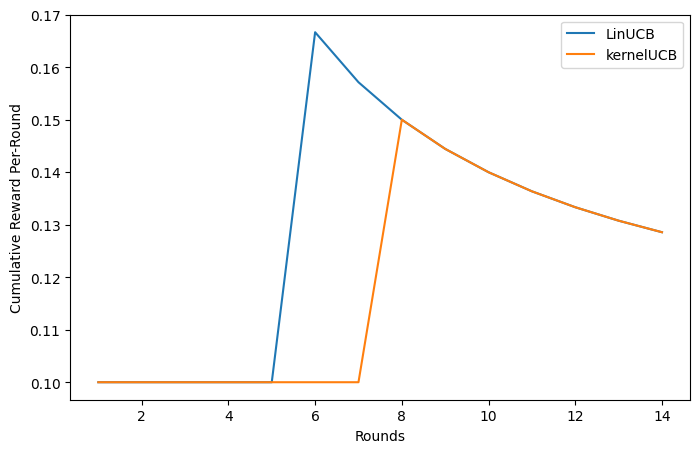

In [9]:
# plotting code here LinUCB vs Kernel UCB
best_lin_results, best_ker_results, round_list = [], [], []        # create lists for results
n_rounds = 800                                                     # the total number of rounds 
best_lin_sum, best_ker_sum = 0, 0                                  # set the initial reward sum

best_lin_mab = LinUCB(n_arms, n_dims, best_alpha)
best_results_LinUCB = offlineEvaluate(best_lin_mab, arms, rewards, contexts,n_rounds)
# run UCB algorithms
best_kernel_mab = KernelUCB(n_arms, n_dims, best_gamma, best_eta , rbf_kernel)
best_results_KernelUCB = offlineEvaluate(best_kernel_mab, arms, rewards, contexts, n_rounds)

# Use actual number of results returned
actual_rounds = min(len(best_results_LinUCB), len(best_results_KernelUCB))
print(f"LinUCB matched: {len(best_results_LinUCB)} events")
print(f"KernelUCB matched: {len(best_results_KernelUCB)} events")
print(f"Plotting {actual_rounds} rounds")

for n_round in range(1, actual_rounds + 1):
    best_lin_sum += best_results_LinUCB[n_round-1] 
    best_ker_sum += best_results_KernelUCB[n_round-1]
    
    # append cumulative rewards
    best_lin_results.append(best_lin_sum/n_round)
    best_ker_results.append(best_ker_sum/n_round)
    round_list.append(n_round)

# plot 
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(round_list, best_lin_results, label = "LinUCB")
plt.plot(round_list, best_ker_results, label = "kernelUCB")

plt.ylabel('Cumulative Reward Per-Round')
plt.xlabel('Rounds')
plt.legend()
plt.show()

In [10]:
# Show ALS candidates vs Bandit selection

# Pick a sample user to demonstrate
sample_user_id = user_map[0]  # First user in the matrix
if sample_user_id in user_inv_map:
    user_idx = user_inv_map[sample_user_id]
    
    # Get ALS recommendations (all 20 candidates)
    user_row = user_item_sparse[user_idx]
    als_recs = als_model.recommend(
        user_idx,
        user_row,
        N=20,
        filter_already_liked_items=False
    )
    candidate_indices, scores = als_recs
    candidate_items = [item_map[idx] for idx in candidate_indices if idx in item_map]
    
    print(f"📋 ALS generated {len(candidate_items)} candidates for User {sample_user_id}:")
    print("="*80)
    for i, (item_id, score) in enumerate(zip(candidate_items[:20], scores[:20]), 1):
        print(f"  {i:2d}. Item {item_id:10d} (ALS score: {score:.4f})")
    
    # BANDIT SELECTION: Choose top 5 products to display
    print("\n🤖 BANDIT RECOMMENDATION (LinUCB):")
    print("="*80)
    
    # Simulate user state (you can change these values)
    user_views = 10
    user_addtocart = 0
    user_transactions = 0
    user_state = np.array([user_views, user_addtocart, user_transactions], dtype=float)
    
    print(f"User context: {user_views} views, {user_addtocart} addtocart, {user_transactions} transactions")
    print("\nBandit selects these 5 products (in order) to maximize conversion:")
    print("-"*80)
    
    # Create context for all 20 arms
    context = np.tile(user_state, (20, 1))
    
    # Use the trained LinUCB bandit to select top N products
    N = 5
    selected_arms = []
    remaining_candidates = list(range(20))
    
    for rank in range(N):
        if not remaining_candidates:
            break
            
        # Calculate scores for remaining candidates
        best_score = -np.inf
        best_arm = None
        
        for arm in remaining_candidates:
            # Calculate UCB score for this arm
            inv_A = best_lin_mab.inv_A[arm]
            theta = best_lin_mab.theta[arm]
            ucb_score = theta @ context[arm] + best_lin_mab.alpha * np.sqrt(context[arm].T @ inv_A @ context[arm])
            
            if ucb_score > best_score:
                best_score = ucb_score
                best_arm = arm
        
        if best_arm is not None:
            selected_arms.append(best_arm)
            remaining_candidates.remove(best_arm)
            
            item_id = candidate_items[best_arm]
            als_score = scores[best_arm]
            print(f"  {rank+1}. Item {item_id:10d} (Position #{best_arm+1} in ALS, ALS score: {als_score:.4f}, UCB score: {best_score:.4f})")
    
    print("\n" + "="*80)
    print("💡 Interpretation:")
    print("   - ALS generated 20 relevant products based on collaborative filtering")
    print("   - Bandit reranked them based on user's current state to maximize reward")
    print("   - This personalized ordering increases conversion probability")
    print("="*80)
    
else:
    print("Sample user not found in training data")

📋 ALS generated 19 candidates for User 2:
   1. Item      30094 (ALS score: 0.0061)
   2. Item      56695 (ALS score: 0.0032)
   3. Item     423748 (ALS score: 0.0023)
   4. Item      64104 (ALS score: 0.0021)
   5. Item     432566 (ALS score: 0.0020)
   6. Item     434946 (ALS score: 0.0019)
   7. Item     335418 (ALS score: 0.0017)
   8. Item      62388 (ALS score: 0.0015)
   9. Item     130827 (ALS score: 0.0015)
  10. Item      63206 (ALS score: 0.0015)
  11. Item     461311 (ALS score: 0.0013)
  12. Item     313698 (ALS score: 0.0013)
  13. Item     466539 (ALS score: 0.0013)
  14. Item      40808 (ALS score: 0.0011)
  15. Item     285192 (ALS score: 0.0011)
  16. Item     276435 (ALS score: 0.0011)
  17. Item     141240 (ALS score: 0.0011)
  18. Item      66014 (ALS score: 0.0011)
  19. Item     417358 (ALS score: 0.0010)

🤖 BANDIT RECOMMENDATION (LinUCB):
User context: 10 views, 0 addtocart, 0 transactions

Bandit selects these 5 products (in order) to maximize conversion:
-----